<h2>Fábio Rosindo Daher de Barros</h2>
<h3>Data scientist, Machine learning engineer</h3>
<h4>E-mail: <a>fabio.rosindo.daher.de.barros@gmail.com</a></h4>
<h4>Phone: +55 11 963930316</h4>
<h4>Linkedin: <a>https://www.linkedin.com/in/fabiordb<a></h4>

In [1]:
from __future__ import division
import warnings
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import collections
from scipy.stats import pearsonr as Pearson
import statistics as stats
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import autocorrelation_plot
from datetime import datetime, timedelta
import pandas as pd
import scipy
import scikits.bootstrap as bootstrap
warnings.filterwarnings("ignore")
base_file = 'sample.txt'
%matplotlib inline

/usr/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<h3>Reading and removing unused data</h3>
<p>Removing versaoDocumento, infAdic and emit</p>

In [2]:
data = pd.read_json(base_file)
data.drop(['versaoDocumento', 'infAdic', 'emit'], axis=1, inplace=True)
temp = []

<h4>Manipulating the Json interesting data for a Dataframe</h4>
<p>Applying as columns : ValorTotal, Quantidade, Itens, Date, Imposto</p>
<p>Is important for us select for DataFrame: Sale amount, quantity, list products, date and tax</p>

In [3]:
for i in range(0,len(data)):
    vt = data['complemento'][i]['valorTotal']
    itens = data['dets'][i]
    qntdd = len(data['dets'][i])
    date = data['ide'][i]['dhEmi']['$date']
    imposto = data['total'][i]['icmsTot']['vTotTrib']
    temp.append([vt, qntdd, itens, date, imposto])
cols = ['total', 'qnt', 'itens', 'data', 'imposto']
del data
fd = pd.DataFrame(temp, columns=cols) #filtered data
fd['data'] = pd.to_datetime(fd['data'])
del temp;temp = []
c = 0
for i in fd.itens:
    for j in i:
        prod  = j['prod']['xProd']
        typo  = j['prod']['uCom']
        total = j['prod']['vProd']
        qnt   = j['prod']['qCom']
        unp   =j['prod']['vUnCom']
        dia  = fd['data'][c]
        temp.append([c, prod, typo, total, qnt, unp, dia])
    c = c +1

<h3>What is our Product Ranking by sale?</h3>
<p>On below, we have a ranking by frequency to order. You can see the Buffet as first, followed by soda and water</p>

In [4]:
cols = ['saleid', 'prod', 'tipo', 'total', 'qnt', 'unp', 'dt']
products = pd.DataFrame(temp, columns=cols)
print products['prod'].value_counts()

BUFFET            1635
REFRIGERANTE       778
AGUA               417
SUCO               184
CERVEJA             93
CHA                 85
CERVEJA LATA        64
LIMONADA            56
DOCINHOS            49
SUSHI ESPECIAL      46
SAKE                36
CAFE EXPRESSO       20
SOBREMESA           17
WHISKY              16
TEMAKI              14
CAIPIROSKA           9
BULE CHA             8
CAIPIRINHA           7
YAKISSOBA            4
HARUMAKI             3
SASHIMI              3
BACARDI              1
URAMAKI              1
VINHO                1
Name: prod, dtype: int64


<h2>Lunch or Dinner?</h2>
<h4>Which slice of the day our clients most like to appear?</h4>

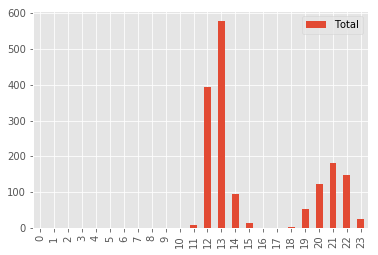

In [5]:
slice_days = fd.groupby(pd.Grouper(key='data', freq='H', axis=0))
#print slice_days.total.count()
slice_days = slice_days.total.count()
start_dt = '2016-01-05 12:00:00'
end_dt   = '2016-01-23 14:00:00'

def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta
        
del temp; temp = []
c= 0
start_date = datetime(2016, 1, 5, 12, 0)
end_date = datetime(2016, 1, 23, 14, 0)
for single_date in daterange(start_date, end_date):
    temp.append([single_date.strftime("%H:%M"), slice_days[c]])
    #temp.append([single_date, slice_days[c]])
    c = c + 1

hist = {}
for i in temp:
    if i[0] in hist:
        hist[i[0]] = hist[i[0]] + i[1]
    else:
        hist[i[0]] = i[1]
pd.DataFrame([hist[j] for j in ["%02d:00" % i for i in range(0,24)]], columns=['Total']).plot(kind='bar')


<h4>As we can see above, the lunch time is the winner of the battle!</h4>
<h5>It's clear the lunch time. The midday between(12:00 - 14:00), the volumn is too big compared with other ranges. </h5>

<h3>Which we sell more BUFFET or Drinks?<h3> 
<p>Here we can understand in quantity we sell more Drinks than Buffet graphically</p>

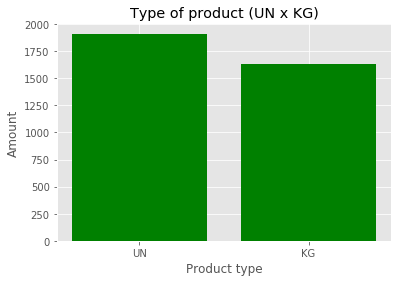

In [6]:
plt.bar([i for i, _ in enumerate(list(products['tipo'].value_counts()))] , list(products['tipo'].value_counts()), color='green')
plt.xlabel("Product type")
plt.ylabel("Amount")
plt.title("Type of product (UN x KG)")
plt.xticks([i for i, _ in enumerate(list(products['tipo'].value_counts()))] , [str(r) for r in list(products['tipo'].value_counts().index)])
plt.show()

<h3>Correlation between Amount x Tax</h3>

In [7]:

print(str('PEARSON CORRELATION TOTAL x TAX = ')+str(Pearson(fd['total'], fd['imposto'])[0]))

PEARSON CORRELATION TOTAL x TAX = 0.831520552835


<p>On chart below, we can check graphically the strong correlation between both variables</p>

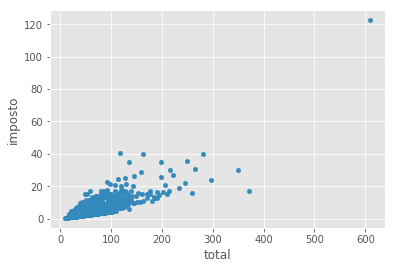

In [8]:
fd.plot(kind='scatter', x='total', y='imposto')
plt.show()

<h3>What is our tickets?</h3>
<p>Which we sell more in mean?</p>
<p> You can below our general ticket </p>

In [9]:
print '*'*20
print "Ticket total average = "+(str(stats.mean(products['total'].astype('float')))[:5])
print '*'*20

********************
Ticket total average = 25.58
********************


In [10]:
#other way to discover avg ticket
print '\nTicket total average\n'
print '*'*20
print products[['total']].describe()
print '*'*20


Ticket total average

********************
             total
count  3547.000000
mean     25.587826
std      28.452314
min       1.000000
25%       4.500000
50%      14.000000
75%      34.980000
max     335.860000
********************


<h3>Our Drink ticket</h3>

In [11]:
print '\n Drink total average ticket "UN" \n'
print '*'*20
print products[products['tipo'] == 'UN']['total'].describe()
print '*'*20
print "Drink total average titcket = R$ "+(str(stats.mean(products[products['tipo'] == 'UN']['total'].astype('float')))[:4])
print '*'*20


 Drink total average ticket "UN" 

********************
count    1912.000000
mean        7.968881
std         9.649195
min         1.000000
25%         4.500000
50%         4.500000
75%        10.500000
max       295.000000
Name: total, dtype: float64
********************
Drink total average titcket = R$ 7.96
********************


<h3>Our Buffet consumption in Money and KG</h3>

In [12]:
print '\nBuffet total average ticket "KG"\n'
print '*'*20
kg_prod = products[products['tipo'] == 'KG']
print kg_prod[['total', 'qnt']].describe()
print '*'*20
print "Buffet total average ticket = R$ "+(str(stats.mean(products[products['tipo'] == 'KG']['total'].astype('float')))[:5])
print '*'*20


Buffet total average ticket "KG"

********************
             total          qnt
count  1635.000000  1635.000000
mean     46.191755     0.673403
std      29.323780     0.427472
min       7.680000     0.112000
25%      26.470000     0.386000
50%      36.630000     0.534000
75%      58.510000     0.853000
max     335.860000     4.896000
********************
Buffet total average ticket = R$ 46.19
********************


<h3>BUFFET weighted average consumption</h3>
<p>Here we see the average of weight unit consumption</p>

In [13]:
print '\nAVERAGE BUFFET TICKET "KG" \n'
print '*'*20
print "Mean consumption (Amount of wheight BUFFET = "+(str(stats.mean(products[products['tipo'] == 'KG']['qnt'].astype('float')))[:5])+" w.u. (weight unit)"
print '*'*20


AVERAGE BUFFET TICKET "KG" 

********************
Mean consumption (Amount of wheight BUFFET = 0.673 w.u. (weight unit)
********************


<h3>Group sales data by daily and weekly</h3>
<p>In the first section, we group the data by daily and weekly</p>
<p>At the second section, We have the boxplot to analyze the distribuition of the variables and the scale</p>

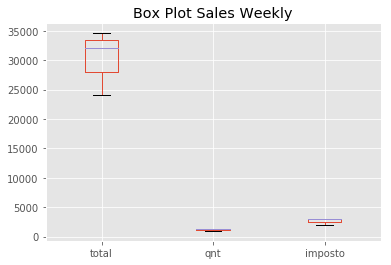

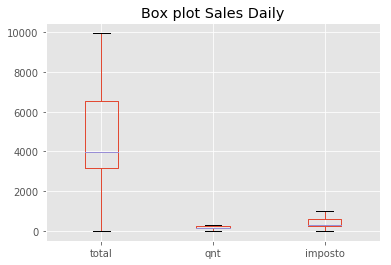

In [37]:
daily_sales = fd.groupby(pd.TimeGrouper(key='data', freq='1D', axis=0))
weekly_sales = fd.groupby(pd.TimeGrouper(key='data', freq='1W'))

weekly_sales = weekly_sales.sum().fillna(0)
daily_sales = daily_sales.sum().fillna(0)

weekly_sales.boxplot()
plt.title('Box Plot Sales Weekly')
plt.show()

daily_sales.boxplot()
plt.title('Box plot Sales Daily')
plt.show()

In [38]:
X = daily_sales[['total']].values          

<h2>Modeling and predictions</h2>

<h4>Applying autocorrelation to understand the ARIMA parameters</h4>

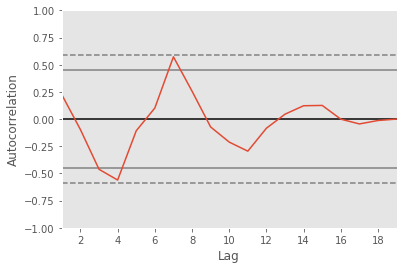

In [39]:
autocorrelation_plot(X)
plt.show()

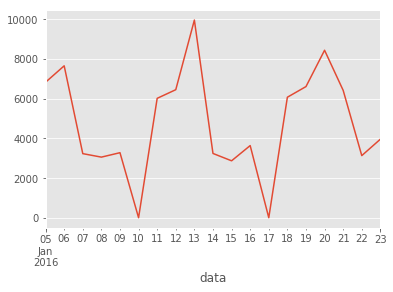

In [47]:
daily_sales.total.plot()

<p>I choose apply a Time series model, because we can see a regime in our data and the Serie has a pattern with a strongly aderence.</p>

Optimization terminated successfully.
         Current function value: 5.993594
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 10
         Hessian evaluations: 5
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   11
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 -65.930
Method:                           css   S.D. of innovations           2979.666
Date:                Fri, 23 Feb 2018   AIC                            141.859
Time:                        08:55:31   BIC                            141.589
Sample:                             5   HQIC                           138.516
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.

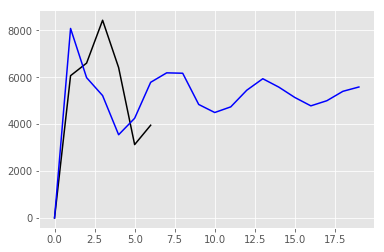

In [48]:
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
predictions = list()

model = ARIMA(train, order=(4,1,0))
model_fit = model.fit(trend='nc', disp=7, solver='ncg', method='css', maxiter=3500)
output = model_fit.forecast(alpha=0.05, steps=20)
yhat = output
predictions.append(yhat)
print(model_fit.summary())

leng = len(test)
error = mean_squared_error(test, yhat[0][:leng])
print('Test MSE: %.3f' % error)
yhat[0].put(0,0)
plt.plot(test, color='black')
plt.plot(yhat[0], color='blue')
plt.show()

<p>Here we go, checking the test and prediction correlation<p>

In [49]:
pv =  yhat[0][:leng]
pt = np.asarray([i[0] for i in test])
Pearson(pv, pt)

(0.6849688060009379, 0.089498073686591323)

Both sides are with good correlations. So, now let's group the data to predict the weelky data.

<h1>Let's start the predictions!</h1>
<p>Synchronize the array indexes with days jumping weekends</p> 

In [50]:
#size     #05 - 16
#yhat[0]  #17 18 19 20 21 22 23 24 25 26 27 28 29 30 31    Days
         # 0  1  2  3  4  5  6 7  8  9  10 11 12 13 14    Indexes
         #                     0                    0     Weekends

<h4>Sum the indexes related to the next week.</h4> 

In [51]:
print sum(yhat[0][8:14])

31622.5050409


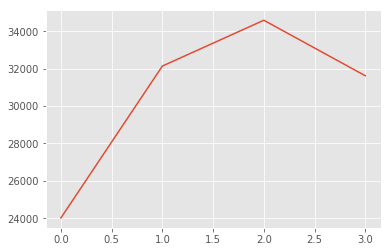

In [52]:
var = weekly_sales.total.values
var = np.append(var, sum(yhat[0][8:14]))
plt.plot([i for i in range(0, len(var))], var)
plt.show()

<h3>Let's predict the amount of meals (in weight) we will need deliver in next week.</h3>

In [53]:
daily_food = products[products['tipo'] == 'KG'][['qnt', 'dt']].groupby(pd.TimeGrouper(key='dt', freq='1D', axis=0))
weekly_food = products[products['tipo'] == 'KG'][['qnt', 'dt']].groupby(pd.TimeGrouper(key='dt', freq='1W'))

weekly_food = weekly_food.sum().fillna(0)
daily_food = daily_food.sum().fillna(0)

<h3>Seeing the behavior of the Daily food consumption</h3>

Axes(0.125,0.125;0.775x0.755)


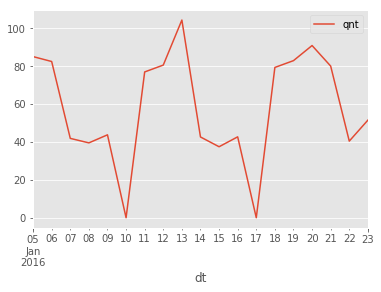

In [54]:
print daily_food.plot()

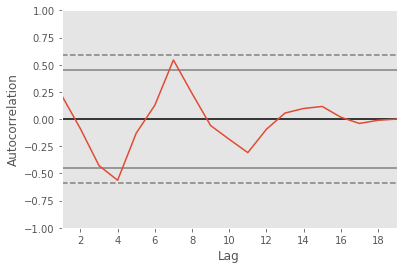

In [55]:
X = daily_food[['qnt']].values  
     
autocorrelation_plot(X)
plt.show()

Optimization terminated successfully.
         Current function value: 3.362726
         Iterations: 119
         Function evaluations: 258
         Gradient evaluations: 258
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   11
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 -36.990
Method:                           css   S.D. of innovations             24.651
Date:                Fri, 23 Feb 2018   AIC                             85.980
Time:                        08:55:44   BIC                             86.457
Sample:                             4   HQIC                            82.765
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6412        nan   

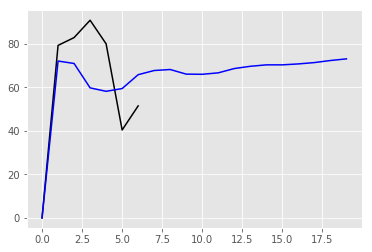

In [56]:
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
predictions = list()

model = ARIMA(train, order=(3,1,1))
model_fit = model.fit(trend='c', disp=20, solver='cg', method='css', maxiter=4500)
output = model_fit.forecast(alpha=0.03, steps=20)
yhat = output
predictions.append(yhat)
print(model_fit.summary())

leng = len(test)
error = mean_squared_error(test, yhat[0][:leng])
print('Test MSE: %.3f' % error)
yhat[0].put(0,0)
plt.plot(test, color='black')
plt.plot(yhat[0], color='blue')
plt.show()

pv =  yhat[0][:leng]
pt = np.asarray([i[0] for i in test])
Pearson(pv, pt)

In [57]:
pv =  yhat[0][:leng]
pt = np.asarray([i[0] for i in test])
Pearson(pv, pt)

(0.82915509028560253, 0.021086630717466016)

<p>The best configuration this model according to the autocorrelation parameters was the setup above.</p>

In [58]:
#size     #05 - 16
#yhat[0]  #17 18 19 20 21 22 23 24 25 26 27 28 29 30 31    Days
         # 0  1  2  3  4  5  6 7  8  9  10 11 12 13 14    Indexes
         #                     0                    0     Weekends

<h3>As Sales prediction, let's group the predictions</h3>

In [59]:
print sum(yhat[0][8:14])

404.981927603


<h3>The Food serie</h3>

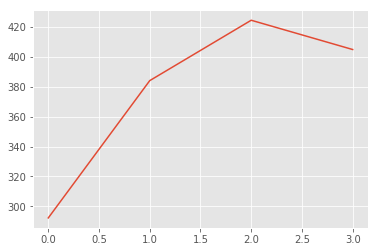

In [60]:
var = weekly_food.qnt.values
var = np.append(var, sum(yhat[0][8:14]))
plt.plot([i for i in range(0, len(var))], var)
plt.show()

<h3>Here we go to analyze the new serie, validating some statistical features</h3>
<p>First step is Boxplot check, to understand the precdiction is following the serie average.</p>
<p>Check the density, to see the confidence inteval graficaly.</p>

         Food
0  292.276000
1  384.165000
2  424.573000
3  404.981928


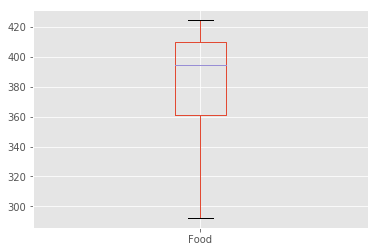

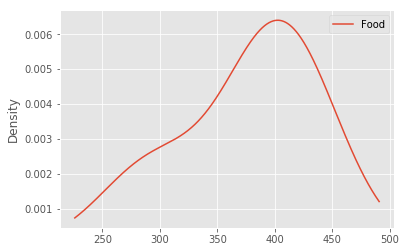

In [61]:
print pd.DataFrame(var, columns=['Food'])
pd.DataFrame(var, columns=['Food']).plot(kind='box')
pd.DataFrame(var, columns=['Food']).plot(kind='density')

<h3>Now, we will evaluate the confidence interval.</h3>

In [62]:
 CIs = bootstrap.ci(data=var, statfunction=scipy.mean)
print "Bootstrapped 95% confidence intervals\nLow:", CIs[0], "\nHigh:", CIs[1]

Bootstrapped 95% confidence intervals
Low: 292.276 
High: 409.879695702


<p>The prediction is inside of the Confidence interval.</p>
<h3> It means we need to be prepared for next week with a stock for near 409 u.w of food.</h3>
<p>As it is a sample, we have a low amount of data. Who can generate a noises on predictions.
<br>But as both predictions are inside the confidence interval, I believe the both predictions make sense.<p>
